# 1. Using historical data for score prediction

The purpose of this notebook is to investigate how previous results can be used to predict future scores in football. The starting hypothesis is that that the combination of a team's chance creation for and the opponent's chance creation against can be used to estimate how many goals will be scored by each side. Since football is a low volume game with volatile result, the hypothesis is that *Expected Goals* is a better parameter than Actual Goals scored. This notebook will test that hypothesis.

To determine the best parameter, a season average will be calculated for *Expected Goals Scored (xGS)*, *Expected Goals Against (xGA)*, *Goals Scored (GS)* and *Goals Against (GA)*, and will be used to calculate a *Projected Goals Scored (pGS)* for each team, using below formula. The parameter with the lowest *Mean Absolute Error (MAE)* against actual scores will be deemed the best.

$(w_t \times TpGS) + (1-w_t) \times OpGA$ 

where 
- $TpGS$ is the Team's projected Goals Scored,
- $OpGA$ is the Opponent's projected Goals Against and
- $w_t$ is the weighting factor deciding on how dependant scores are on team's offensive record vs opponent's defensive record [0-1]

To convert projected goals scored into odds probabilities, poisson distribution will be used, comparing *pGS* against *pGA* and estimating probabilities for a win, draw and loss.

## 1.0. The data

The data used comes from fbref.com, which tracks scores and expected scores for a lot of leagues around the world. In scripts/fbref dir, we fetch this data for all leagues where fbref tracks expected stats per game.

Below leagues are used with data from 2017-2018 onwards.

- Premier League
- Championship
- Serie A
- Serie B
- La Liga
- Bundesliga
- 2\. Bundesliga
- Ligue 1
- Ligue 2
- Eredivisie
- Primeira Liga

In [1]:
# Importing base packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
import seaborn as sns

# Importing paths and custom functions
from sportsbook.config import fbref_results_csv_path # CSV path for fbref match results
from sportsbook.config import main_directory
from sportsbook.custom_funcs import pivot_result_df # Pivots match data into one row per team and match
from sportsbook.custom_funcs import get_cumulative_season_average # Takes df data and returns a list with the cumulative season average for each matchday.

In [2]:
results_df = pd.read_csv(fbref_results_csv_path)
results_df.sample(5)

,season,league,league_id,gameweek,match_date,home_team,home_xg,home_score,away_team,away_xg,away_score
2708,2018-2019,Championship,10,16,2018-11-03,Stoke City,0.6,0,Middlesbrough,0.8,0
1688,2021-2022,Premier League,9,18,2021-12-19,Tottenham,3.0,2,Liverpool,1.1,2
18210,2021-2022,2 Bundesliga,33,24,2022-02-25,Paderborn 07,2.0,3,Erzgebirge Aue,3.2,3
18201,2021-2022,2 Bundesliga,33,23,2022-02-18,Dresden,1.8,1,Heidenheim,0.6,1
11370,2019-2020,Bundesliga,20,8,2019-10-19,Augsburg,2.3,2,Bayern Munich,3.1,2


Data format is one row per match, with stats for away team and home team. When working with trends and performance per team, we instead want it in a pivoted format, like below.

Notice that a field called *match_no* is added. This is due to the field gameweek denoting the planned gameweek of the game, rather than the actual order of which games were played.

In [3]:
team_stats_df = pivot_result_df(results_df)
team_stats_df.sample(5)

,match_id,season,league,league_id,gameweek,match_date,team,expected_goals_scored,goals_scored,opponent,expected_goals_conceded,goals_conceded,home_away,match_no
32683,10174,2022-2023,Serie A,11,10,2022-10-17,Fiorentina,0.5,1,Lecce,1.1,1,away,10
30690,10060,2021-2022,Serie A,11,37,2022-05-15,Napoli,2.4,3,Genoa,1.1,0,home,37
18194,17731,2020-2021,2 Bundesliga,33,5,2020-10-23,Nürnberg,0.8,1,Karlsruher,0.6,1,home,5
37395,2272,2022-2023,Premier League,9,38,2023-05-28,Fulham,1.8,1,Manchester Utd,2.9,2,away,38
40500,2444,2023-2024,Premier League,9,17,2023-12-16,Everton,1.4,2,Burnley,0.7,0,away,17


## 1.1. Actual Goals vs Expected Goals

As noted above, the hypothesis is that expected goals *(xG)* is better than actual goals to predict future scores. In this section we will test that statement.

To do that, we:

1. Create season average team goals scored ($TGS$) and average opponent goals against ($OGA$), as well as  $TxGS$ and $OxGA$
2.   For different values of $w_t$, we check the difference in pGS and actual goals scored
3. If hypothesis is correct, pGS based on $xG$ should be closer to actual goals scored, and yield a smaller Mean Absolute Error (MAE).

In [4]:
# Using custom function get_cumulative_season_average to get the season average state before the game was played
team_stats_df['TxGS'] = get_cumulative_season_average(team_stats_df,'team','expected_goals_scored')
team_stats_df['OxGA'] = get_cumulative_season_average(team_stats_df,'opponent','expected_goals_scored')
team_stats_df['TGS'] = get_cumulative_season_average(team_stats_df,'team','goals_scored')
team_stats_df['OGA'] = get_cumulative_season_average(team_stats_df,'opponent','goals_scored')

team_stats_df.sample(5)

,match_id,season,league,league_id,gameweek,match_date,team,expected_goals_scored,goals_scored,opponent,expected_goals_conceded,goals_conceded,home_away,match_no,TxGS,OxGA,TGS,OGA
1562,123,2017-2018,Premier League,9,13,2017-11-25,Swansea City,0.9,0,Bournemouth,0.4,0,home,13,0.816667,1.441667,0.583333,1.166667
18816,19592,2020-2021,Serie B,18,8,2020-11-21,Pordenone,2.3,1,Monza,2.0,1,home,8,1.385714,1.016667,1.142857,0.666667
25983,15910,2021-2022,Ligue 2,60,14,2021-10-30,Toulouse,1.1,2,Guingamp,1.5,2,home,14,1.684615,1.238462,2.307692,1.153846
15259,13220,2019-2020,Eredivisie,23,23,2020-02-15,ADO Den Haag,0.5,0,PSV Eindhoven,3.8,3,home,23,1.231818,1.240909,1.045455,1.181818
34583,20504,2022-2023,Serie B,18,23,2023-02-04,Ternana,0.8,0,Cosenza,0.6,0,away,23,1.168182,1.286364,1.090909,1.590909


Looping through different values of $w_t$ to analyse both the quality between expected projected goals ($xpGS$) and actual projected goals ($apGS$), as well as the importance ratio between $T(x)GS$ and $O(x)GA$ 

In [5]:
mae_per_weight_df = pd.DataFrame(columns=['metric','weight','mae'])

# Testing values of w_t from 0 to 1
for i in range(0,11):
    w_t = i/10
    team_stats_df['xpGS'] = w_t * team_stats_df['TxGS'] + (1-w_t)*team_stats_df['OxGA']
    team_stats_df['apGS'] = w_t * team_stats_df['TGS'] + (1-w_t)*team_stats_df['OGA']
    team_stats_df['xMAE'] = abs(team_stats_df['xpGS']-team_stats_df['goals_scored'])
    team_stats_df['aMAE'] = abs(team_stats_df['apGS']-team_stats_df['goals_scored'])
    mae_per_weight_df.loc[len(mae_per_weight_df)] = ['actual',str(w_t),round(team_stats_df['aMAE'].mean(),3)]
    mae_per_weight_df.loc[len(mae_per_weight_df)] = ['expected',str(w_t),round(team_stats_df['xMAE'].mean(),3)]

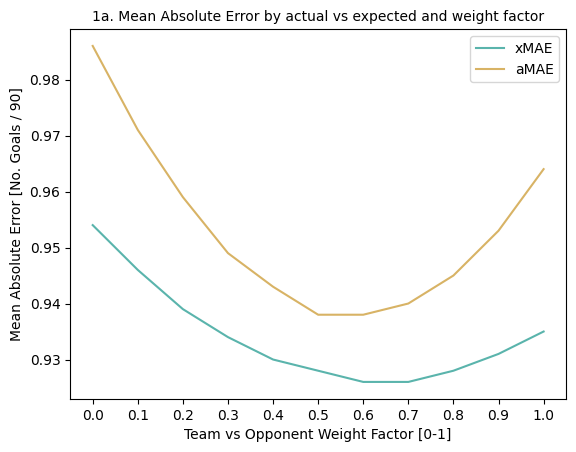

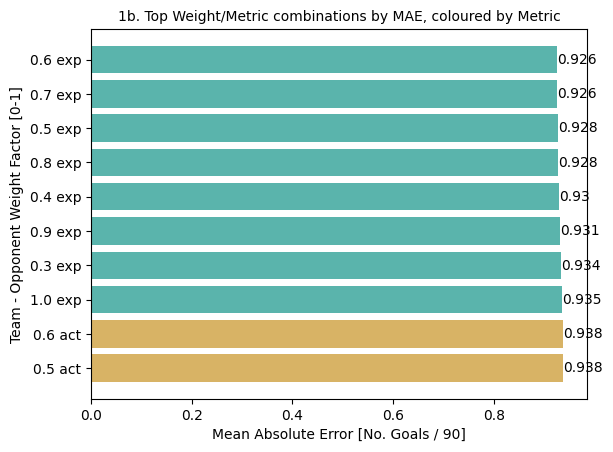

In [6]:
# Line chart comparing xMAE and aMAE per weight factor value
plt.plot(mae_per_weight_df.loc[mae_per_weight_df['metric']=='expected','weight'],mae_per_weight_df.loc[mae_per_weight_df['metric']=='expected','mae'],label='xMAE',color='#5ab4ac')
plt.plot(mae_per_weight_df.loc[mae_per_weight_df['metric']=='actual','weight'],mae_per_weight_df.loc[mae_per_weight_df['metric']=='actual','mae'],label='aMAE',color='#d8b365')
plt.legend()
plt.xlabel('Team vs Opponent Weight Factor [0-1]')
plt.ylabel('Mean Absolute Error [No. Goals / 90]')

plt.title('1a. Mean Absolute Error by actual vs expected and weight factor',fontsize=10)
plt.savefig(r'figures/1a. Mean Absolute Error by actual vs expected and weight factor.png')
plt.show()

# Bar plot with top 10 combinations
bar_df = mae_per_weight_df.sort_values('mae',ascending=False).reset_index(drop=True)
bar_df = bar_df[-10:]
bar_df['colour'] = '#d8b365'
bar_df.loc[bar_df['metric']=='expected','colour'] = '#5ab4ac'
bars = plt.barh(bar_df['weight'] +' '+ bar_df['metric'].str[:3],bar_df['mae'],color=bar_df['colour'])
plt.title('1b. Top Weight/Metric combinations by MAE, coloured by Metric',fontsize=10)
plt.xlabel('Mean Absolute Error [No. Goals / 90]')
plt.ylabel('Team - Opponent Weight Factor [0-1]')
plt.bar_label(bars)
plt.savefig(r'figures/1b. Top Weight-Metric combinations by MAE, coloured by Metric.png')
plt.show()


As figure x shows, $xpGS$ outperforms $apGS$ consistently for all values of $w_t$. When plotting the top 10, we see that the 8 best performing combinations are using expected goals

We can also see that both the team's offensive contribution and the opponent's defensive contribution matter when projecting goals scored. The ideal weight seem to be around 0.6-0.7, where a team's offensive performance is slightly more important than the opponent's defensive strength

## 1.2. Testing the best performing metric

As seen above, the best performing combination seem to be to use *Expected Goals*, and to use a weight of 0.6/0.7 (Here we use 0.65).

First we want to see performance over the course of a season.

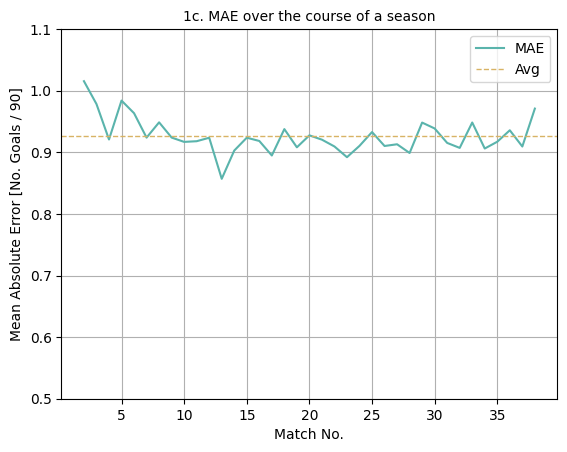

Average: 0.926
Remove 3: 0.922
Remove 5: 0.920
Remove 10: 0.918
Remove 15: 0.921


In [7]:
team_stats_df['xpGS'] = 0.65 * team_stats_df['TxGS'] + 0.35 * team_stats_df['OxGA']
team_stats_df['xmae'] = abs(team_stats_df['xpGS']-team_stats_df['goals_scored'])
mae_per_gw_df = team_stats_df.groupby('match_no')['xmae'].mean().reset_index()

# Removing last gws (most leagues have 38 games)
mae_per_gw_df = mae_per_gw_df.loc[mae_per_gw_df['match_no']<39]

plt.plot(mae_per_gw_df['match_no'],mae_per_gw_df['xmae'],label='MAE',color='#5ab4ac')
plt.axhline(y=np.nanmean(mae_per_gw_df['xmae']), color='#d8b365', linestyle='--', linewidth=1, label='Avg')
plt.xlabel('Match No.')
plt.ylabel('Mean Absolute Error [No. Goals / 90]')
plt.ylim([0.5,1.1])
plt.legend()
plt.grid()
plt.title('1c. MAE over the course of a season',fontsize=10)
plt.savefig(r'figures/1c. MAE over the course of a season.png')
plt.show()

print('Average: {:.3f}'.format(mae_per_gw_df['xmae'].mean()))
print('Remove 3: {:.3f}'.format(mae_per_gw_df.loc[mae_per_gw_df['match_no']>3,'xmae'].mean()))
print('Remove 5: {:.3f}'.format(mae_per_gw_df.loc[mae_per_gw_df['match_no']>5,'xmae'].mean()))
print('Remove 10: {:.3f}'.format(mae_per_gw_df.loc[mae_per_gw_df['match_no']>10,'xmae'].mean()))
print('Remove 15: {:.3f}'.format(mae_per_gw_df.loc[mae_per_gw_df['match_no']>15,'xmae'].mean()))

mae_per_gw_df['metric'] = 'season_avg_xg'
mae_per_gw_df.to_csv(r'data/1c.mean_absolute_error_per_gw.csv')

I removed gameweeks *39-46*, since that is only used by Championship and is therefor more volatile. As we see the performance is quite consistent during a season, with the exception of the beginning gameweeks. This is natural since the average then is based on few games and a team's form is still unclear.

When removing beginning gameweeks, we see that the performance improves slightly, after 10 games the projected goals are ~1.5% better than when the entire season is included.

## 1.3. Win probabilities from historical data

Here we try to predict wins, ties and losses using $xpGA$ and $xpGS$. To do this, we are using a Poisson Distribution,

$P\left( x \right) = \frac{{e^{ - \lambda } \lambda ^x }}{{x!}}$

where,

- $x$ is the number of goals scored per 90
- $\lambda$ is the mean goals scored per 90, i.e. $xpGS$ and $xpGA$

In [8]:
# Creating xpGA in the same way we create xpGS
team_stats_df['TxGA'] = get_cumulative_season_average(team_stats_df,'team','expected_goals_conceded')
team_stats_df['OxGS'] = get_cumulative_season_average(team_stats_df,'opponent','expected_goals_conceded')

team_stats_df['xpGA'] = 0.65 * team_stats_df['OxGS'] + 0.35 * team_stats_df['TxGA']
team_stats_df = team_stats_df.dropna()
team_stats_df = team_stats_df.drop_duplicates('match_id')

We perform a test for one sample game, using the following formula

$P_{win} = \sum_{i=0}^{10}\sum_{j=0}^{10} P\left( i \right) * P\left( j \right)$, if $i > j$

$P_{draw} = \sum_{i=0}^{10}\sum_{j=0}^{10} P\left( i \right) * P\left( j \right)$, if $i = j$

$P_{loss} = \sum_{i=0}^{10}\sum_{j=0}^{10} P\left( i \right) * P\left( j \right)$, if $i < j$


In [9]:
# Probability function, added to sportsbook packages as "customfunc.get_score_probability"
def get_score_probability(row):
    pWin = 0
    pTie = 0
    pLoss = 0

    # For goals scored in range 0 to 10, check the probability that opponent has scored less, equal or more goals according to the projected goals scored
    for i in range(0,11):
        prob_i = poisson.pmf(k=i,mu=row['xpGS'])
        
        if i>0:
            prob_smaller = poisson.cdf(k=(i-1), mu=row['xpGA'])
        else:
            prob_smaller = 0
        prob_same = poisson.pmf(k=i,mu=row['xpGA'])
        prob_larger = 1-poisson.cdf(k=i, mu=row['xpGA'])
        
        pWin += prob_i * prob_smaller
        pTie += prob_i * prob_same
        pLoss += prob_i * prob_larger
    return pd.Series({'pWin': pWin, 'pTie': pTie, 'pLoss': pLoss})
        

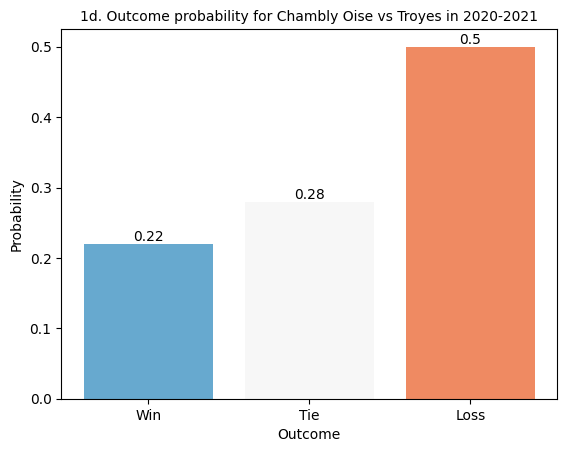

In [10]:
# Selecting random example match
example_df = team_stats_df.sample(1).reset_index(drop=True)

# Fetching the win, tie and loss probability
example_df[['pWin', 'pTie', 'pLoss']] = example_df.apply(get_score_probability, axis=1)

# Bar plot with the different outcomes
bars = plt.bar(['Win','Tie','Loss'],[round(example_df.loc[0,'pWin'],2),round(example_df.loc[0,'pTie'],2),round(example_df.loc[0,'pLoss'],2)],color=['#67a9cf','#f7f7f7','#ef8a62'])
plt.bar_label(bars)
plt.xlabel('Outcome')
plt.ylabel("Probability")
plt.title('1d. Outcome probability for {} vs {} in {}'.format(example_df.loc[0,'team'],example_df.loc[0,'opponent'],example_df.loc[0,'season']),fontsize=10)
plt.savefig(r'figures/1d. Outcome percentage for one game.png')
plt.show()


We now want to expand this to the entire dataset, calculating the win, tie and loss probability for the entire dataframe.

The point of this is to bin the probabilities, and again calculate the MAE between projected probability and actual probability.

In [11]:
# Fetching win, tie and loss probability for entire df (removing duplicates and n/a first)
team_stats_df = team_stats_df.dropna()
team_stats_df = team_stats_df.drop_duplicates('match_id')

team_stats_df[['pWin', 'pTie', 'pLoss']] = team_stats_df.apply(get_score_probability, axis=1)

In [12]:
# Getting the probability vs actual results and pivoting the table so win, tie and loss is separate rows
score_predictions_df = team_stats_df[['match_id','goals_scored','goals_conceded','pWin','pTie','pLoss']]
score_predictions_pivoted_df = pd.melt(score_predictions_df,id_vars=['match_id','goals_scored','goals_conceded'])

score_predictions_pivoted_df['actual'] = 0

# Set to 1 if variable row equals the outcome of the game
score_predictions_pivoted_df.loc[((score_predictions_pivoted_df['variable']=='pWin') & (score_predictions_pivoted_df['goals_scored'] > score_predictions_pivoted_df['goals_conceded'])) | ((score_predictions_pivoted_df['variable']=='pTie') & (score_predictions_pivoted_df['goals_scored'] == score_predictions_pivoted_df['goals_conceded'])) | ((score_predictions_pivoted_df['variable']=='pLoss') & (score_predictions_pivoted_df['goals_scored'] < score_predictions_pivoted_df['goals_conceded'])),'actual'] = 1

# Assigning bins
bin_limits = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
score_predictions_pivoted_df['probability_bin'] = pd.cut(score_predictions_pivoted_df['value'],bin_limits)

# Getting aggregated value for each bin
bins_df = score_predictions_pivoted_df.groupby(['probability_bin'],observed=True).agg(
    projected_mean=pd.NamedAgg(column='value', aggfunc='mean'),
    count = pd.NamedAgg(column='value',aggfunc='count'),
    observed_mean=pd.NamedAgg(column='actual', aggfunc='mean')
).reset_index()
bins_df['mean_absolute_error'] = abs(bins_df['projected_mean']-bins_df['observed_mean'])
bins_df['weighted_mae'] = bins_df['mean_absolute_error']*bins_df['count']

weighted_mae = bins_df['weighted_mae'].sum()/bins_df['count'].sum()

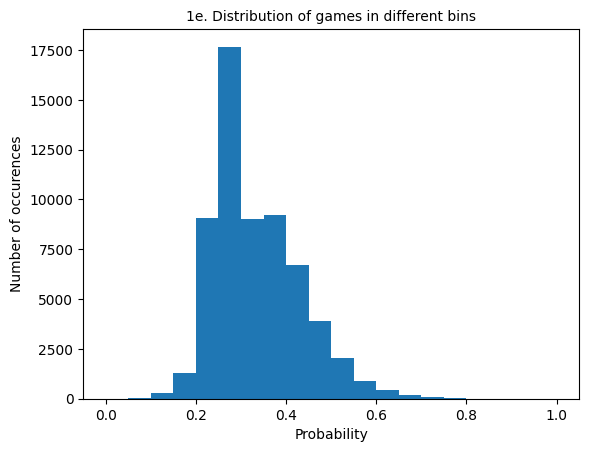

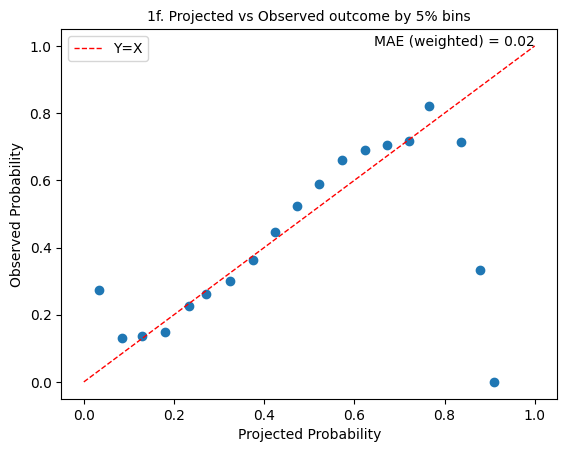

In [13]:
# Plotting histogram and bar chart

# Histogram w. no. of occurences per bin
plt.hist(score_predictions_pivoted_df['value'], bins=bin_limits)
plt.title('1e. Distribution of games in different bins',fontsize=10)
plt.xlabel('Probability')
plt.ylabel('Number of occurences')
plt.savefig(r'figures/1e.no_games_per_bin.png')
plt.show()

# Scatter plot comparing projected probability w. observed probability
plt.scatter(bins_df['projected_mean'],bins_df['observed_mean'])
plt.plot(bin_limits,bin_limits,label='Y=X',color='red',linestyle='--', linewidth=1)
plt.legend()
plt.text(1,1,'MAE (weighted) = {:.2f}'.format(weighted_mae),fontsize=10,ha='right')
plt.xlabel('Projected Probability')
plt.ylabel('Observed Probability')
plt.title('1f. Projected vs Observed outcome by 5% bins',fontsize=10)
plt.savefig(r'figures/1f.projected_vs_observed_outcome_by_bin.png')
plt.show()

bins_df['metric'] = 'season_avg_xg'
bins_df.to_csv(r'data/1f.projected_vs_observed_outcome.csv',index=False)

We can see that when we check the mean value of each bin with the mean outcome of each bin, we get a 2% difference on the dataset as a whole, which is acceptable as a starting point. 
We can see that the Mean Absolue Error is larger at the tail end of each probability scale, which is probably an effect of a small sample size in these probabilities. For probabilities in the span of [0.15,0.8] we can see that the observed means are close to the reference line.

Below we are using another binning method where each bin contains the same amount of games. Here we can instead see that the projected mean in each bin seem to consistently match the observed mean.

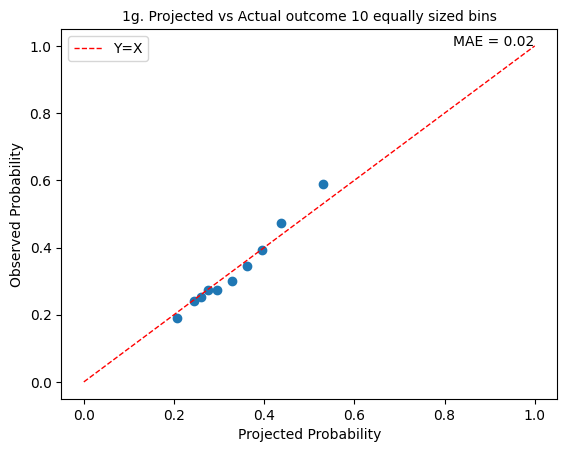

In [14]:
decimals = pd.qcut(score_predictions_pivoted_df['value'],10)
score_predictions_pivoted_df = score_predictions_pivoted_df.assign(dec_bin=decimals.values)

bins_df = score_predictions_pivoted_df.groupby('dec_bin',observed=True).agg(
    projected_mean=pd.NamedAgg(column='value', aggfunc='mean'),
    count = pd.NamedAgg(column='value',aggfunc='count'),
    observed_mean=pd.NamedAgg(column='actual', aggfunc='mean')
)
bins_df['mae'] = abs(bins_df['projected_mean']-bins_df['observed_mean'])
bins_df['me'] = bins_df['observed_mean']-bins_df['projected_mean']

mae = bins_df['mae'].mean()

plt.scatter(bins_df['projected_mean'],bins_df['observed_mean'])
plt.plot(bin_limits,bin_limits,label='Y=X',color='red',linestyle='--', linewidth=1)
plt.legend()
plt.text(1,1,'MAE = {:.2f}'.format(mae),fontsize=10,ha='right')
plt.xlabel('Projected Probability')
plt.ylabel('Observed Probability')
plt.title('1g. Projected vs Actual outcome 10 equally sized bins',fontsize=10)
plt.savefig(r'figures/1g.projected_vs_actual_outcome_by_q_bins.png')
plt.show()

## 1.4. Conclusion and Next Step

The analysis seem to indicate that the use of season average expected goals can be used to predict future results in football. We can also assume that expected goals are a better indicator than actual goals.

Next step is to add odds data, and test if we can get a net positive by using our model to find >1 ROI bets.